### 预训练的词嵌入简介

#### 何时使用

训练数据样本少时，无法进行特定任务的词嵌入

#### 为什么可以使用预训练词嵌入

选择的第三方训练好的词嵌入是
- 一个高度结构化的，
- 而且具有的属性是有用的，
- 该属性具有语言结构的一般性特点。

这样的原理跟使用预训练的卷积神经网络一样：
- 没有足够的数据来完成特征提取
- 需要使用一些通用的特征
- 我们这里是语义特征

所以可以利用预训练好的词嵌入，辅助我们的来实现文本向量化。

#### 词嵌入的经典算法

**Bengio 的低维词嵌入空间**  

用无监督的方法计算一个密集的低维词嵌入空间

[相关的论文](BENGIO Y, SCHWENK H, SENÉCAL J S, et al. Neural probabilistic language models [M Berlin, Heidelberg: Springer, 2003)  
**word2vec 算法**  
word2vec 算法由 Google 的 Tomas Mikolov 于 2013 年开发，其维度抓住了特定的语义属性，比如性别。  

**GloVe**
由斯坦福大学的研究人员于 2014 年开发。这种嵌入方法基于对词共现统计矩阵进
行因式分解。其开发者已经公开了数百万个英文标记的预计算嵌入，它们都是从维基百科数据
和 Common Crawl 数据得到的  



### 从零搭建一个文本模型

将句子嵌入到向量序列中，然后将其展平，最后在上面训练一个 Dense 层。但此处将使用预训练的词嵌入。

#### 下载 IMDB 数据的原始文本

在如下[网址下载](http://mng.bz/0tIo)  

在下载文件图片如下
![aclImdb文件夹](imgs/04.jpg)
![train文件夹](imgs/05.jpg)
![neg文件夹](imgs/06.jpg)

这里第一步就是将文件中的内容读出来，并保存在一个列表中，同时将对于的数据的标签也保存。


In [5]:
import os

# 训练数据文件path
imdb_dir = 'G:/Data/ch06_glove/aclImdb'
train_dir = os.path.join(imdb_dir,'train')

labels =[]
texts = []

# 从neg,pos文件中读取
for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        # 判断文件是不是有效的文本
        if fname[-4:] == '.txt':
            # 读取文件到列表texts中,这里最好要将字符的编码带上
            f = open(os.path.join(dir_name,fname),encoding='utf-8')
            texts.append(f.read())
            f.close()
            # 并制作对应得标签
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                    

In [14]:
print(len(texts))
print(texts[0])
print(len(labels))
print(labels[0])

25000
Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.
25000
0


#### 对数据进行分词

将训练数据限定为前 200 个样本。因此，你需要在读取 200 个样本之后学习对电影评论进行分类。
里面使用了Keras中的[Tokenizer类](https://keras.io/preprocessing/text/#tokenizer)。
Tokenizer类的作用：
- 将每个文本转化为一个整数序列（每个整数都是词典中标记的索引）
- 或者将其转化为一个向量，

`Tokenizer(num_words=max_words)`主要参数
- num_words: 需要保留的最大词数，基于词频。只有最常出现的 num_words 词会被保留。
- filters: 一个字符串，其中每个元素是一个将从文本中过滤掉的字符。默认值是所有标点符号，加上制表符和换行符，减去 ' 字符。
- lower: 布尔值。是否将文本转换为小写。
- split: 字符串。按该字符串切割文本。
- char_level: 如果为 True，则每个字符都将被视为标记。
- oov_token: 如果给出，它将被添加到 word_index 中，并用于在 text_to_sequence 调用期间替换词汇表外的单词。

本例中主要使用了参数：num_words=max_words

In [65]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# 每条评论只截取前100个单词进行训练和预测
maxlen = 100
# 训练样本选择10000条评论数据
training_samples =10000
# 验证集，选择10000条评论数据
validation_samples = 10000
# 只选择数据中前10000个常见的数据
max_words = 10000

#最常出现的 num_words 词会被保留
tokenizer = Tokenizer(num_words=max_words)
# Transforms each text in texts to a sequence of integers.
tokenizer.fit_on_texts(texts)
# 将文本转换为单词（或标记）的序列
sequences = tokenizer.texts_to_sequences(texts)

# dictionary mapping words (str) to their rank/index 
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# 将数据截断成相等的长度
data = pad_sequences(sequences,maxlen=maxlen)

# 将数据转换成一个numpy数组数据
labels = np.asarray(labels)
print('shape of data tensor:',data.shape)
print('Shape of label tensor:',labels.shape)

# 打乱数据
# 首先获得数据的数组0-25000个数剧
indices = np.arange(data.shape[0])
# 打乱数据
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# 获得测试数据和验证数据
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]



Found 87393 unique tokens.
shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


#### 下载 GloVe 词嵌入

[网址如下]( https://nlp.stanford.edu/projects/glove)
这里使用的是： 2014 年英文维基百科的预计算嵌入。
![2014 年英文维基百科](imgs/07.jpg)

#### 对嵌入进行预处理
我们对解压后的文件（一个 .txt 文件）进行解析，构建一个将单词（字符串）映射为其向
量表示（数值向量）的索引
![glove txt](imgs/08.jpg)

创建一个embedding层矩阵，它必须是一个形状为(max_words,  embedding_dim) 的矩阵


In [66]:
glove_dir = 'G:/Data/ch06_glove'
embeddings_index = { }
# 构建一个字典：选择的是100维的空间
# 一个词对应的维度是100
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [67]:
print(embeddings_index['cat'].shape)

(100,)


In [68]:
embedding_dim = 100

# 嵌入矩阵创建
embedding_matrix = np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [69]:
print(embedding_matrix.shape)

(10000, 100)


#### 定义模型
我们将使用与上一篇中相同的模型架构

In [70]:
# 在 IMDB 数据上使用 Embedding 层和分类器
from keras.models import Sequential
from keras.layers import Flatten,Dense,Embedding

model = Sequential()
# 指定 Embedding 层的最大输入长度，以便后面将嵌入输入展平。
# Embedding 层激活的形状为 (samples, 100, 100)
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))

# 将三维的嵌入张量展平成形状为 (samples, maxlen * 8) 的二维张量
model.add(Flatten())
model.add(Dense(32, activation='relu')) 
model.add(Dense(1,activation='sigmoid'))

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### 在模型中加载 GloVe 嵌入
Embedding 层只有一个权重矩阵，是一个二维的浮点数矩阵，其中每个元素 i 是与索引 i
相关联的词向量。

In [72]:
# 将嵌入的数据权重填入到模型中并且设置为不可训练层
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#### 训练模型与评估模型

这里建议如果训练的数据多的话，还是使用自己的数据重新训练为好。

In [73]:
model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])
history = model.fit(x_train,y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val,y_val))
#model.save_weights('per_trained_glove100_model.h5')
model.save_weights('per_trained_glove100_model10000.h5')

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 171us/step - loss: 0.6817 - acc: 0.5861 - val_loss: 0.6472 - val_acc: 0.6177
Epoch 2/10
10000/10000 [==============================] - 1s 132us/step - loss: 0.5573 - acc: 0.7250 - val_loss: 0.5676 - val_acc: 0.7073
Epoch 3/10
10000/10000 [==============================] - 1s 134us/step - loss: 0.4719 - acc: 0.7788 - val_loss: 0.6551 - val_acc: 0.6629
Epoch 4/10
10000/10000 [==============================] - 1s 135us/step - loss: 0.4130 - acc: 0.8132 - val_loss: 0.6169 - val_acc: 0.6935
Epoch 5/10
10000/10000 [==============================] - 1s 132us/step - loss: 0.3555 - acc: 0.8465 - val_loss: 0.6447 - val_acc: 0.6925
Epoch 6/10
10000/10000 [==============================] - 1s 132us/step - loss: 0.3083 - acc: 0.8699 - val_loss: 0.7054 - val_acc: 0.6856
Epoch 7/10
10000/10000 [==============================] - 1s 136us/step - loss: 0.2660 - acc: 0.8899 - val_loss: 0.7200 - 

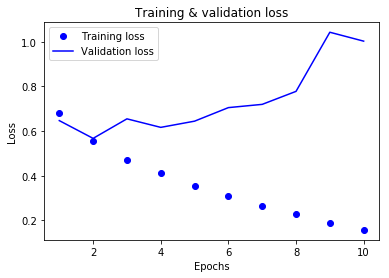

In [74]:
# 绘制训练损失贺验证损失
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title("Training & validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

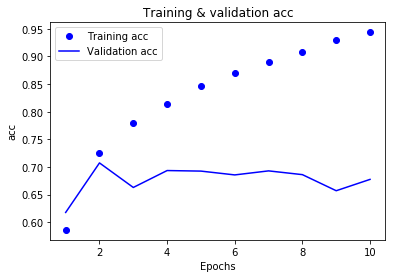

In [75]:
# 绘制训练精度和验证集的精度
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs,acc_values,'bo',label='Training acc')
plt.plot(epochs,val_acc_values,'b',label='Validation acc')
plt.title("Training & validation acc")
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

#### 测试模型


In [63]:
# 测试模型
test_dir = os.path.join(imdb_dir, 'test') 
 
labels = [] 
texts = [] 
 
for label_type in ['neg', 'pos']: 
    dir_name = os.path.join(test_dir, label_type) 
    for fname in sorted(os.listdir(dir_name)): 
        if fname[-4:] == '.txt': 
            f = open(os.path.join(dir_name, fname),encoding='utf-8') 
            texts.append(f.read()) 
            f.close() 
            if label_type == 'neg': 
                labels.append(0) 
            else: 
                labels.append(1) 
 
sequences = tokenizer.texts_to_sequences(texts) 
x_test = pad_sequences(sequences, maxlen=maxlen) 
y_test = np.asarray(labels)


In [77]:
#model.load_weights('per_trained_glove100_model.h5')
model.load_weights('per_trained_glove100_model10000.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 1s 40us/step


[1.5393994842910768, 0.53176]

In [78]:
#不加载预训练词嵌入、也不冻结嵌入层的情况
# 如果训练数据多还是使用自己训练的模型，这样精度更高一些
from keras.models import Sequential 
from keras.layers import Embedding, Flatten, Dense 
 
model2 = Sequential() 
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen)) 
model2.add(Flatten()) 
model2.add(Dense(32, activation='relu')) 
model2.add(Dense(1, activation='sigmoid')) 
model2.summary() 
 
model2.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc']) 
history2 = model2.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 220us/step - loss: 0.4999 - acc: 0.7406 - val_loss: 0.3719 - val_acc: 0.8321
Epoch 2/10
10000/10000 [==============================] - 2s 169us/step - lo